## Modelos de regresión lineal

### Hipotesis

¿Cuánto gastará un cliente en su próxima transacción, según su historial reciente y sus hábitos operativos?

El monto de una transacción puede estimarse a partir de las características operativas y de comportamiento del cliente, considerando la frecuencia reciente de operaciones (TxnCountInLast24Hours), la recencia de actividad (Recency), la intensidad monetaria promedio del cliente (Monetary), el tiempo desde la última transacción registrada (TimeSinceLastTxn) y la desviación del gasto respecto al promedio local (AmountZScoreByLocation).

En este análisis se busca determinar en qué medida los patrones transaccionales y temporales influyen en el valor esperado de una nueva transacción, utilizando modelos de regresión continua (Lineal, Ridge, Lasso, ElasticNet, MLPRegressor).

Este enfoque permite evaluar el grado de dependencia entre el comportamiento histórico del cliente y los montos de sus operaciones futuras, mediante métricas como el coeficiente de determinación (R²) y el error cuadrático medio (MSE), reflejando la precisión del modelo en la predicción del valor monetario.


#### Variables	
    - TxnCountInLast24Hours	(Número de transacciones en las últimas 24 horas).
    - Recency	(Días desde la última transacción del cliente).
    - Monetary	(total gastado por el cliente en el periodo).
    - TimeSinceLastTxn	(Intervalo temporal entre las transacciones).
    - AmountZScoreByLocation	(Desviación del monto respecto al promedio local).
    - TransactionAmount (INR)	(Variable objetivo – continua) Monto individual de la transacción).

In [3]:
# =========================================================
# 🔌 Cargar entorno y librerías
# =========================================================
%load_ext kedro.ipython

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# =========================================================
# 1️⃣ Cargar dataset desde Kedro
# =========================================================
df = catalog.load("Features_training_v2").copy()
print("Shape del dataset:", df.shape)

# =========================================================
# 2️⃣ Seleccionar variables según la hipótesis
# =========================================================
features = [
    "Monetary",
    "TimeSinceLastTxn",
    "Recency",
    "TxnCountInLast24Hours",
    "AmountZScoreByLocation"
]
target = "TransactionAmount (INR)"

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[10/24/25 01:47:35] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=416958;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=201376;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Shape del dataset: (984240, 6)


===== Métricas del Modelo Lineal =====
R²: 0.966
MSE: 23692.473
RMSE: 153.924
MAE: 91.052

===== Validación Cruzada (R²) =====
R² medio (CV): 0.966
Desviación estándar: 0.0


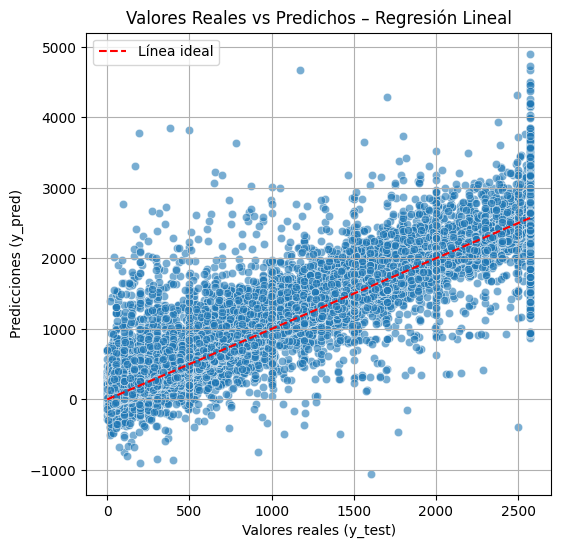

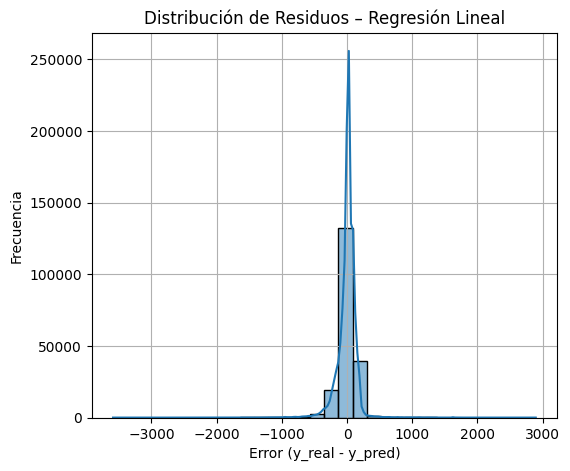

[10/24/25 01:47:58] WARNING  C:\Users\Kevin\AppData\Local\Temp\ipykernel_5748\2259789942.py:77:     ]8;id=980848;file://C:\Python313\Lib\warnings.py\warnings.py]8;;\:]8;id=105179;file://C:\Python313\Lib\warnings.py#110\110]8;;\
                             FutureWarning:                                                                        
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(data=coef_df, x='Coeficiente', y='Variable',                            
                             palette='Blues_r')                                                                    
                                                                                                                   

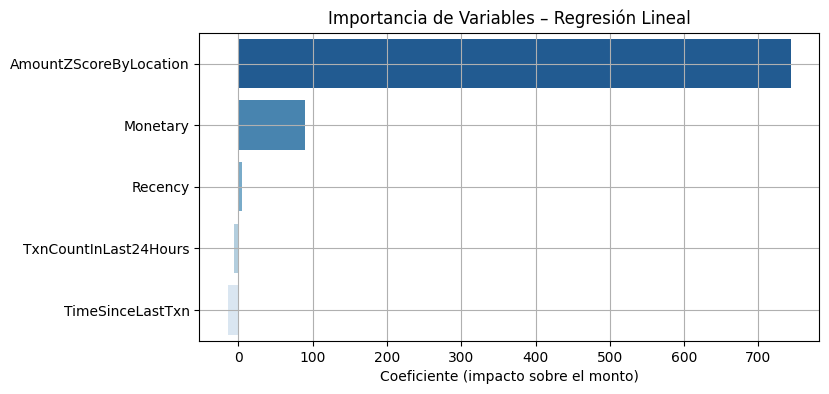

In [4]:
# =========================================================
# 3️⃣ División Train/Test + Estandarización
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================================
# 4️⃣ Entrenamiento del modelo base
# =========================================================
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# =========================================================
# 5️⃣ Evaluación del modelo
# =========================================================
y_pred = lin_reg.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("===== Métricas del Modelo Lineal =====")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# =========================================================
# 6️⃣ Validación cruzada (k-fold)
# =========================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring="r2")

print("\n===== Validación Cruzada (R²) =====")
print("R² medio (CV):", round(cv_r2.mean(), 3))
print("Desviación estándar:", round(cv_r2.std(), 3))

# =========================================================
# 7️⃣ Gráficos de evaluación
# =========================================================

# 🎯 a) Valores Reales vs Predichos
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='Línea ideal')
plt.title("Valores Reales vs Predichos – Regresión Lineal")
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 b) Distribución de los residuos
residuals = y_test - y_pred
plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribución de Residuos – Regresión Lineal")
plt.xlabel("Error (y_real - y_pred)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# 🎯 c) Coeficientes del modelo
coef_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': lin_reg.coef_
}).sort_values(by='Coeficiente', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=coef_df, x='Coeficiente', y='Variable', palette='Blues_r')
plt.title("Importancia de Variables – Regresión Lineal")
plt.xlabel("Coeficiente (impacto sobre el monto)")
plt.ylabel("")
plt.grid(True)
plt.show()


El modelo de Regresión Lineal alcanzó un coeficiente de determinación R² = 0.966, lo que indica que el 96.6 % de la variabilidad del monto de transacción puede explicarse a partir de las variables de comportamiento y operación consideradas. Las métricas de error (MSE = 23 692.47, RMSE = 153.92, MAE = 91.05) muestran un nivel bajo de desviación entre los valores reales y predichos, confirmando un ajuste preciso del modelo. Además, la validación cruzada (R² medio = 0.966) evidencia una alta estabilidad y consistencia en diferentes subconjuntos de datos, sin indicios de sobreajuste. El gráfico y_real vs y_pred muestra una relación fuertemente lineal, lo que valida la idoneidad de este modelo como línea base para comparaciones posteriores.

En cuanto a la interpretación de los coeficientes, el modelo revela que la variable AmountZScoreByLocation tiene el mayor impacto positivo sobre el monto de la transacción, seguida por Monetary, lo que sugiere que los clientes con desviaciones altas de gasto respecto a su entorno y con mayor gasto histórico tienden a realizar operaciones de mayor valor. Las variables Recency, TimeSinceLastTxn y TxnCountInLast24Hours presentan influencias menores, lo cual indica que el tiempo entre operaciones y la frecuencia reciente tienen un efecto más débil en el monto individual. La distribución de residuos concentrada alrededor de cero respalda la buena calibración del modelo y confirma que los errores no presentan sesgo sistemático.